In [606]:
from __future__ import division
import numpy as np
BUY = 1
SELL = -1
FUND = int(1000000) #ファンダメンタル価格（実験中は不変で全員共通のためグローバル変数にした）
N_STY = 1000 #スタイライズドトレーダーの数
N_MAKER = 1 #マーケットメイカーの数
DUR = 20000 #注文が自動で取り消されるまでの時間
PRICES = [FUND] #0~t-1期までの株価の推移，0期にはファンダメンタル価格とする
T = 1 #今が何期目かを示す．
VOLA = 0.006 
orderVOLA = 30 #スタイライズドトレーダーの発注価格の標準偏差
SPREAD = 0.001 #マーケットメイカーのスプレッド割合


"""
T，PRICESとDUR，FUNDはMARKETクラス固有の数として組み込んでもよいかも
現状，特にシミュレーション中に中身が変化するTやPRICESが共通のために
異なる条件での試行や複数回の繰り返しの際にとても面倒になっている
"""

class STYLISED(object):

    def __init__(self,ID):
        #randint(a,b)はa~b-1までの整数での一様分布である
        #rand(a,b)はa~bまでの実数での一様分布である
        self.w1 = np.random.rand()*1
        self.w2 = np.random.rand()*10 #重み付け．各上限は先行研究に従った
        self.w3 = np.random.rand()*1
        self.wsum = self.w1 + self.w2 + self.w3
        self.rag = np.random.randint(1,10000) #テクニカル分析時に何期前までまとめて考えるか．
        self.tech_price = FUND #テクニカル分析時のn期前の価格
        self.price = FUND #直前（1期前）の価格
        self.exprice = FUND #予想される今期の価格
        self.ID = ID

    def update_info(self): 
        """
        情報を得て当期の株価を予想する
        実際にはこの動作の前にグローバル変数PRICESがアップデートされ，その後に行う
        想定ではたとえばT=3，PRICES=[9000,9200,9500],self.rag=4とか
        情報を得るタイミングと注文を出すタイミングに差異があることが予想されるため
        情報取得プロセスと売買決定プロセスは分離した
        """
        self.price = PRICES[-1]
        if T < self.rag: #テクニカル分析の比較対象となる数期前の価格が存在しない場合
            tech_price = FUND
        else:
            tech_price = PRICES[-self.rag]
        fund = self.w1 * (np.log(FUND)-np.log(self.price))
        tech = self.w2 * (np.log(self.price)-np.log(tech_price))
        random = self.w3 * VOLA * np.random.standard_normal()
        self.exprice = self.price * np.exp((fund+tech+random)/self.wsum)
        
    def decision(self): #売買の決定プロセス
        price = self.exprice + orderVOLA * np.random.standard_normal()
        if self.exprice > price:
            order_price = int(price)
            return BUY,order_price,self.ID #注文価格が予想価格より高ければ買い
        else:
            order_price = int(price)+1
            return SELL,order_price,self.ID #注文価格が予想価格より安ければ売り，同じ場合はまずないので無視
        """
        注文に対応するものがあった場合の成行注文化に対応させる必要アリ！
        →マーケット側に組み込んだ（マッチングの際に古い注文の価格が優先されるようにした）
        """
class MAKER(object):
    def __init__(self,ID,spread):#ここのスプレッドはファンダメンタル価格に比した割合，今回は0.1%(0.001)を予定
        self.ID = ID #今回は-1で固定するつもり
        self.margin = FUND*spread/2 #ここのスプレッドは価格の大きさ
        
    def order(self,buy,sell): #2引数はMARKETクラスのindicate_priceで出してくるつもり
        center = (buy+sell)/2
        buy_price = int(center - self.margin)
        sell_price = int(center + self.margin)
        #print buy_price,sell_price
        return buy_price,sell_price,self.ID
        
class MARKET(object):

    
    def __init__(self):
        self.buy_orders = []
        self.sell_orders = []
        self.buy_history = []
        self.sell_history =[]
        
        
    def receive(self,order): #スタイライズドトレーダーの注文受付
        # order means (buy_or_sell,price,ID)
        AR = (order[1],T,order[2]) #価格，注文受付時刻，注文者のID
        if order[0] == BUY:
            self.buy_orders.append(AR)   
        elif order[0] == SELL:
            self.sell_orders.append(AR)   
        else:
            print "ERROR!!"
    
    def sort(self): #注文を価格，時刻の優先順位でソートする
        self.sell_orders.sort(key=lambda x:(x[0],x[1]),reverse = False) 
        #価格，時刻の順で昇順にソートし売り注文の優先順位順に並び替える
        self.buy_orders.sort(key=lambda x:(x[1]),reverse = False)
        self.buy_orders.sort(key=lambda x:(x[0]),reverse = True)
        #価格は降順，時刻は昇順でソートし買い注文の優先順位順に並び替える
        
    def indicate_price(self): #HFTの注文価格算出用に最良気配を提示する
        self.sort()
        if len(self.buy_orders) ==0:
            buy = FUND
        else:
            buy = self.buy_orders[0][0]
        if len(self.sell_orders) ==0:
            sell = FUND
        else:
            sell = self.sell_orders[0][0]
        return (buy,sell)
    
    def delete_old(self): #注文持続期間DURを過ぎて残っている注文を削除
        self.buy_orders.sort(key=lambda x:(x[1]),reverse = False)
        self.sell_orders.sort(key=lambda x:(x[1]),reverse = False)
        switch = 0
        while(switch==0):
            if len(self.buy_orders)==0:
                switch = 1
            elif self.buy_orders[0][1] <= T-DUR:
                self.buy_orders.pop(0)
            else:
                switch = 1
        switch =0
        while(switch==0):
            if len(self.sell_orders)==0:
                switch = 1
            elif self.sell_orders[0][1] <= T-DUR:
                self.sell_orders.pop(0)
            else:
                switch = 1
    
    def clear_history(self): #売買履歴の削除，０期以前に注文を貯めて０期に執行した直後に使用
        self.buy_history = []
        self.sell_history = []
                
    def execution(self): #毎期行う！
        switch = False
        while(switch==False):
            if len(self.buy_orders)==0:
                switch = True
            elif len(self.sell_orders)==0:
                switch = True
            elif self.buy_orders[0][0] < self.sell_orders[0][0]:
                # 再優先される売買注文同士でも売買が成立しない場合，ということ
                switch = True
            else:
                if self.buy_orders[0][1] < self.sell_orders[0][1]:
                    price = self.buy_orders[0][0]
                elif self.buy_orders[0][1] > self.sell_orders[0][1]:
                    price = self.sell_orders[0][0]
                else: #注文時刻が同時の場合（当期注文したトレーダーとHFT間で売買成立）
                    if self.buy_orders[0][2] < self.sell_orders[0][2]:
                        price = self.sell_orders[0][0]
                    else:
                        price = self.buy_orders[0][0]
                    """
                    トレーダーの注文直後にマーケットメイカーが注文を行うことを想定したモデルである
                    よって，トレーダーの注文価格を優先すればよい
                    マーケットメイカーのIDは負値，トレーダーのIDは正値をとらせるためIDが大きい方を優先することで
                    トレーダーの注文価格を優先させたことになる
                    """
                    
                bought = (price,self.buy_orders[0][1],T,self.buy_orders[0][2])
                sold = (price,self.sell_orders[0][1],T,self.sell_orders[0][2])
                # 約定価格，注文時刻，約定時刻，注文者ID
                self.buy_history.append(bought)
                self.sell_history.append(sold)
                """
                買い注文の方が先に出されていた場合
                約定価格は先に出されていた買い注文の価格になる
                """
                self.buy_orders.pop(0) #約定した注文を削除
                self.sell_orders.pop(0)
        
        if len(self.buy_history) == 0:
            current_price = FUND # 一度も売買が行われていない場合にはファンダメンタル価格で対応
        else:
            current_price = (self.buy_history[-1][0]+self.sell_history[-1][0])/2
        PRICES.append(current_price)
        
    def receive_MAKER(self,buy_price,sell_price,ID): #マーケットメイカーからの注文受付
        check = 0
        for order in self.buy_orders: #オーダーからマーケットメイカー由来のものを探しだす作業
            if order[2] == ID:
                order = (buy_price,T,ID)
                check = 1
        if check == 0:
            self.buy_orders.append((buy_price,T,ID))
        check = 0
        for order in self.sell_orders:
            if order[2] == ID:
                order = (sell_price,T,ID)
                check = 1
        if check == 0:
            self.sell_orders.append((sell_price,T,ID))

def format(T,PRICES): #シミュレーションを最初からやり直す際に使用
    T = 1
    PRICES = [FUND]
            

In [608]:
def storage(market,traders,TIMES): 
    #T=0以前に注文を貯める作業．MARKETクラスを持つ引数,STYLISEDクラスのリスト,繰り返し回数を指定する
    global T #Tを編集するため
    T = -len(traders)*TIMES
    for i in range(TIMES):
        for trader in traders:
            trader.update_info()
            order = trader.decision()
            market.receive(order)
            T +=1
    #この段階でT=0のはず
    market.sort() #注文を価格順にソートして
    market.execution() #執行
    market.clear_history() #マッチングした注文は履歴に記録されるが，必要ないので削除
    T += 1 #T=1にして終わり

In [610]:
def SIM_STY(market,traders,TIMES): #マーケットメイカーのいない連続時間ダブルオークション
    global T
    for i in range(TIMES):
        for trader in traders:
            market.delete_old()
            trader.update_info()
            order = trader.decision()
            market.receive(order)
            market.sort()
            market.execution()
            T += 1

def SIM_MAKER(market,traders,makers,TIMES): #マーケットメイカーのいる連続時間ダブルオークション
    global T
    for i in range(TIMES):
        for trader in traders:
            market.delete_old()
            trader.update_info()
            order = trader.decision()
            market.receive(order)
            market.sort()
            market.execution()
            m_price = market.indicate_price
            for maker in makers:
                m_buy,m_sell,m_ID = maker.order(m_price[0],m_price[1])
                market.receive_MAKER(m_buy,m_sell,m_ID)
                """
                疑問点あり
                ここで注文を執行しない場合，もし執行していればこの時点ではマッチングした注文を
                次期のトレーダーがよりよい注文を行った場合に奪われる可能性がある？
                ただ，マーケットメイカーの注文が成行注文になってしまうのはよくない気がする
                成行注文になってしまう場合に指値を変える仕組みを作ったほうがよい？
                そもそも１市場での最良気配同士の中点に注文を出しても絶対に約定しないはず
                中点よりさらに安く買おうとする・高く売ろうとする場合にもやはり成行注文にはならない？
                """
            T += 1

Populating the interactive namespace from numpy and matplotlib


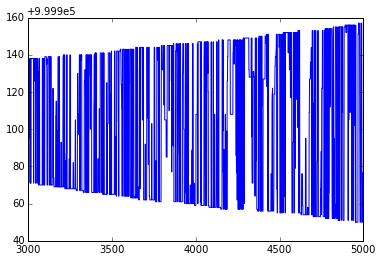

In [616]:
# 価格の動きをプロットしたもの，後で関数化する（PRICESと一緒にMARKETクラスに組み込むのがよいか？）
import matplotlib.pyplot as plt
%pylab inline --no-import-all
#plt.ylim(900000, 1100000)
plt.xlim(3000,5000)
plt.plot(PRICES)
plt.show()

In [560]:
# マーケットメイカーが関与した約定が全体のうちどのぐらいあるのかを調べたい，後で関数化する
number = 0
marketmaker = 0
for i in mar.sell_history:
    if i[2] != 0:
        number += 1
    if i[3] == -1:
        marketmaker += 1
for i in mar.buy_history:
    if i[3] == -1:
        marketmaker += 1
print number
print marketmaker

44427
1750


In [607]:
mar = MARKET()
traders = [STYLISED(i) for i in range(N_STY)]
makers = [MAKER(-i-1,SPREAD) for i in range(N_MAKER)]  

In [611]:
storage(mar,traders,20)

In [612]:
SIM_STY(mar,traders,5)

In [545]:
#バッチオークション版
for i in range(100):
    for batch in batches:
        #print [trader.w1,trader.w2,trader.w3]
        #print np.log(FUND/trader.price)
        batch.update_info()
        order = batch.decision()
        #print mar.buy_orders
        #print mar.sell_orders
        #mar.sort_order()
        MAR.receive(order)
        if T%10==0:
            hft = MAR.indicate_price()
            hft_buy,hft_sell,hft_ID = MM.order(hft[0],hft[1])
            MAR.receive_HFT(hft_buy,hft_sell,hft_ID)
            MAR.sort()
            MAR.execution()
            hft = MAR.indicate_price()
            hft_buy,hft_sell,hft_ID = MM.order(hft[0],hft[1])
            MAR.receive_HFT(hft_buy,hft_sell,hft_ID)
        else:
            PRICES.append(MAR.sell_history[-1][0])
        T += 1
        MAR.delete_old()
        
MAR.sort()
"""
for PRICE in PRICES:
    print PRICE
"""

"""
for i in mar.buy_history:
    print i
"""



'\nfor i in mar.buy_history:\n    print i\n'